Imports

In [1]:
import pandas as pd
import numpy as np

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


Loading the original data

In [2]:
data_sideeffects = pd.read_excel("sider_output.xlsx")
data = pd.read_excel('opioids_data_original.xlsx')
frequencies = pd.read_csv('meddra_freq.tsv', sep='\t', header=None)

Distribution of different outcome labels:

<Axes: >

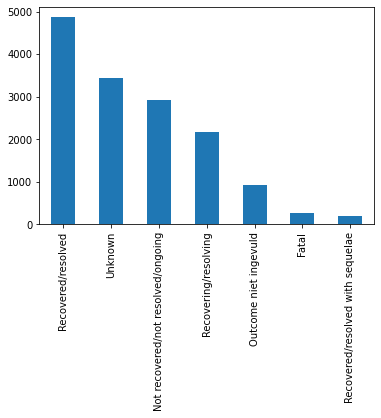

In [3]:
data.Outcome.value_counts().plot(kind='bar')

In [4]:
data['Outcome'].value_counts(normalize=True) * 100

Recovered/resolved                    32.909681
Unknown                               23.201731
Not recovered/not resolved/ongoing    19.808004
Recovering/resolving                  14.663332
Outcome niet ingevuld                  6.280422
Fatal                                  1.852353
Recovered/resolved with sequelae       1.284478
Name: Outcome, dtype: float64

Changing the 'Outcome' column values

<Axes: >

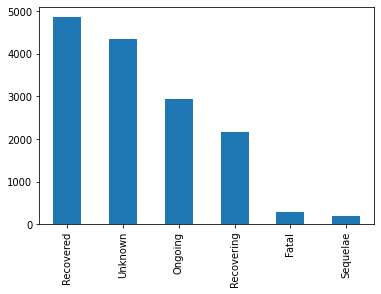

In [5]:
data['Outcome'] = data['Outcome'].replace(['Outcome niet ingevuld', 'Recovered/resolved', 'Not recovered/not resolved/ongoing', 'Recovered/resolved with sequelae', 'Recovering/resolving'], ['Unknown', 'Recovered', 'Ongoing', 'Sequelae', 'Recovering'])
data.Outcome.value_counts().plot(kind='bar')

In [6]:
data['Outcome'].value_counts(normalize=True) * 100

Recovered     32.909681
Unknown       29.482153
Ongoing       19.808004
Recovering    14.663332
Fatal          1.852353
Sequelae       1.284478
Name: Outcome, dtype: float64

Missing values

In [7]:
data.isna().sum()

WorldwideUniqueCaseIdentification        0
Status                                   0
Category                             14792
BodyWeight                            7165
Height                                7477
date_received                            0
sex                                      0
age_year                              2881
Outcome                                  0
OutcomeCodeSystemVersion             10003
OutcomeText                          12925
reaction_impact                      12153
ATCText                                  0
ATCode                                   0
GenericDrugName                          0
ID                                       0
CultureID                                0
LLTCode                                  0
LLTName                                  0
PTCode                                   0
PTName                                   0
HLTCode                                  0
HLTName                                  0
HLTGCode   

Drop columns

In [8]:
data = data.drop(columns=['Primary Source Description', 'Status', 'Category', 'OutcomeCodeSystemVersion', 'OutcomeText', 'CultureID', 'date_received', 'summary', 'narrative', 'IsCurrent', 'IsDefaultSOC'])

Remove outliers

- Removal of instances with bodyweight == 0 
- Removal of instances with height == 0

In [9]:
data = data[data.BodyWeight != 0] 
data = data[data.Height != 0] 

Renaming columns

In [10]:
data['ATCText'].replace(['TRAMADOL MET PARACETAMOL', 'OXYCODON MET NALOXON', 'MORFINE, COMBINATIEPREPARATEN'], ['TRAMADOL', 'OXYCODON', 'MORFINE'], inplace=True)

data['ATCode'].replace(['N02AJ13', 'N02AA51'], ['N02AX02', 'N02AA01'], inplace=True)

data['ATCText'] = data['ATCText'].str.lower()

Replace all non-sense values with NaN

In [11]:
symbols1 = ["-", "_", "\+", "\?", "%", "\*", "\.", "\,", "\:", "\;", "\!", "\@", "\#", "\$", "\^", "\&", "\(", "\)", "\{", "\}", "\[", "\]", "\|", "\/", "\~", "\`", "\=", "\<", "\>", " "]

for i in symbols1:
    data = data.replace(i, "", regex = True)
    data_sideeffects = data_sideeffects.replace(i, "", regex = True)

Replace nan strings with NaN

In [12]:
symbols2 = ["NAN", "NaN", "None", "NaT", "NAT", "nat", "n/a", "N/A", "n/a", "N/A", "n.a.", "N.A.", " "]

for i in symbols2:
    
    # replace symbol in string with "", bit not the whole string
    data = data.replace(rf'\b{i}\b', np.nan, regex = True)
    data_sideeffects = data_sideeffects.replace(rf'\b{i}\b', np.nan, regex = True)

Merging

In [13]:
data = data.merge(data_sideeffects[['ATCode', 'ATCText', 'PTCode', 'Side effect', 'Frequency']], how='left', on=['ATCode', 'ATCText', 'PTCode'])

The 'reaction_impact' column presumably measures the impact the medicine has had on the patient. As shown before, there is no reaction_impact for fatalities. 
We can impute the missing values by taking the average of a patient with similar features. 

To make this easier, we'll first create a column to bin the ages. We'll also create a BMI column and a weight group column.

In [14]:
data['age_group'] = pd.cut(x=data['age_year'], bins=[18, 24, 44, 64, 90])
data['BMI'] = data['BodyWeight'] / (data['Height']/100)**2
data['weight_group'] = pd.cut(x=data['BMI'], bins=[0, 18.5, 25, 30, 50], labels=['underweight', 'normal', 'overweight', 'obese'])
data['WorldwideUniqueCaseIdentification'] = data['WorldwideUniqueCaseIdentification'].str.replace(" ", "")
data['age_group'] = data['age_group'].astype(str)
data['PTCode'] = data['PTCode'].astype(str)

Imputing missing values

In [15]:
data['Frequency'] = data['Frequency'] * 100
data['Frequency'] = data['Frequency'].replace(0.0, 0.0001)
data['Frequency'] = data['Frequency'].fillna(0.0)
data['is_sideeffect'] = data['Side effect'].notna()

In [16]:
data.reset_index(drop=True)
data.columns

Index(['WorldwideUniqueCaseIdentification', 'BodyWeight', 'Height', 'sex',
       'age_year', 'Outcome', 'reaction_impact', 'ATCText', 'ATCode',
       'GenericDrugName', 'ID', 'LLTCode', 'LLTName', 'PTCode', 'PTName',
       'HLTCode', 'HLTName', 'HLTGCode', 'HLTGName', 'SOCCode', 'SOCName',
       'SOCAbbreviation', 'Side effect', 'Frequency', 'age_group', 'BMI',
       'weight_group', 'is_sideeffect'],
      dtype='object')

Split the column generic drugname into two columns: type and dosage

In [17]:
gdn = list(data['GenericDrugName'].str.split(' ', expand=True).stack().unique())
type = ['CAPSULE', 'NEUSSPRAY', 'TABLET', 'PLEISTER', 'INJVLST', 'ZETPIL', 'DRANK', 'SPRAY', 'ZUIGTABLET', 'BRUISTABLET', 'INJ/INFOPL', 'INFVLST', 'DRUPPELS', 'SMELTTABLET', 'INJECTIE/INFUUS', 'DISPERTABLET', 'TAB', 'INJECTIEPOEDER']
dosage = []

def has_numbers(inputString):
    return bool(re.search(r'\d', inputString))

for i in gdn:
    if has_numbers(i):
        dosage.append(i)

data['Type'] = data['GenericDrugName'].apply(lambda x : ''.join([k for k in str(x).split() if k in type]))
data['Dosage'] = data['GenericDrugName'].apply(lambda x : ''.join([k for k in str(x).split() if k in dosage]))

In [18]:
data = data.reset_index(drop=True)

In [19]:
data.isna().sum()

WorldwideUniqueCaseIdentification        0
BodyWeight                            7165
Height                                7477
sex                                      0
age_year                              2879
Outcome                                  0
reaction_impact                      12011
ATCText                                  0
ATCode                                   0
GenericDrugName                          0
ID                                       0
LLTCode                                  0
LLTName                                  0
PTCode                                   0
PTName                                   0
HLTCode                                  0
HLTName                                  0
HLTGCode                                 0
HLTGName                                 0
SOCCode                                  0
SOCName                                  0
SOCAbbreviation                          0
Side effect                           8555
Frequency  

In [20]:
data.to_excel("opioid_datamerged.xlsx") 